In [1]:

import pickle
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from neuralforecast.auto import AutoLSTM, AutoRNN, AutoGRU, AutoMLP, AutoTCN
from neuralforecast.losses.pytorch import MAE, MSE, MQLoss
from neuralforecast import NeuralForecast
import shutil
from ray import tune
from statsmodels.nonparametric.smoothers_lowess import lowess
import utilsforecast.processing as ufp
import logging
import ray
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import json
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
ray.init(log_to_driver=False)
os.environ['NIXTLA_ID_AS_COL'] = '1'

logger = TensorBoardLogger("tb_logs", name="my_model")

plt.rcParams['font.family'] = 'Times New Roman'
np.random.seed(42)
############################################################################################################
logger = False
############################################################################################################
def predictLifespan(data, y_label, lifeDeclineInd = 0.1, stand_value = None):
    x_ticks = np.arange(len(data))
    if stand_value is None:
        stand_value = data.iloc[:10][y_label].mean()
    
    X = x_ticks
    y = data[y_label].values
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X.reshape(-1,1), y)
    step_0 = X[-1] + 1
    step_1 = step_0 + 10
    in1 = 0
    while True:
        pred_range = np.arange(step_0, step_1)

        LR_pred = LR.predict(pred_range.reshape(-1, 1))
        if (stand_value - LR_pred[-1]) / stand_value > lifeDeclineInd or in1 > 30000:

            break
        else:
            step_1 = pred_range[-1] + 10
            in1 += 10

    result = np.concatenate((y, LR_pred))
    decay_period_years = step_1 / 365
    if in1>30000:
        return None, None
    return result, decay_period_years
############################################################################################################

############################################################################################################
def getAutoModel(modelname, h, loss, freq):
    if loss == 'MSE':
        loss_fun = MSE()
    elif loss == 'MQLoss':
        loss_fun = MQLoss(level=[95])
    elif loss == 'MAE':
        loss_fun = MAE()
    modelParameter  = getModelParameter(modelname)
    if modelname == 'RNN':
        models = [AutoRNN(h = h, loss = loss_fun, config = modelParameter, num_samples = 15)]
    elif modelname == 'LSTM':
        models = [AutoLSTM(h = h, loss = loss_fun, config = modelParameter, num_samples = 15)]
    elif modelname == 'GRU':
        models = [AutoGRU(h = h, loss = loss_fun, config = modelParameter, num_samples = 15)]
    elif modelname == 'TCN':
        models = [AutoTCN(h = h, loss = loss_fun, config = modelParameter, num_samples = 15)]
    elif modelname == 'MLP':
        models = [AutoMLP(h = h, loss = loss_fun, config = modelParameter, num_samples = 15)]

    nf = NeuralForecast(models = models, freq = freq, local_scaler_type = 'minmax')
    return nf 

def getModelParameter(modelName):   
    # histogram_callback = WeightHistogramCallback()     
    # histogram_callback = WeightEpochHistogramCallback() 
    final_importance_callback  = FinalLayerImportanceCallback(modelName = modelName)
    if modelName == 'MLP':
        params = {
            "input_size": tune.choice([15, 30]),
            "hidden_size": tune.choice([64, 128, 256, 512, 1024]),
            "num_layers": tune.randint(2, 6),
            "learning_rate": tune.loguniform(1e-4, 1e-1),
            "max_steps": tune.choice([500]),
            "batch_size": tune.choice([16, 32]),
            "windows_batch_size": tune.choice([64, 128, 256, 512, 1024]),
            "random_seed": tune.choice([42]),
            'enable_progress_bar': False,'logger': logger
        }
        
    elif modelName == 'RNN':
        params = {
            "input_size": tune.choice([15, 30]),
            "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
            "encoder_n_layers": tune.randint(1, 4),
            "context_size": tune.choice([5, 10, 50]),
            "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
            "learning_rate": tune.loguniform(1e-4, 1e-1),
            "max_steps": tune.choice([500]),
            "batch_size": tune.choice([16, 32]),
            "random_seed": tune.choice([42]),
            'enable_progress_bar': False,'logger': logger
        }
        
    elif modelName == 'LSTM':
        params = {
            "input_size": tune.choice([15, 30]),
            "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
            "encoder_n_layers": tune.randint(1, 4),
            "context_size": tune.choice([5, 10, 50]),
            "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
            "learning_rate": tune.loguniform(1e-4, 1e-1),
            "max_steps": tune.choice([500]),
            "batch_size": tune.choice([16, 32]),
            "random_seed": tune.choice([42]),
            'enable_progress_bar': False,'logger': logger
        }
        
    elif modelName == 'GRU':
        params = {
            "input_size": tune.choice([15, 30]),
            "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
            "encoder_n_layers": tune.randint(1, 4),
            "context_size": tune.choice([5, 10, 50]),
            "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
            "learning_rate": tune.loguniform(1e-4, 1e-1),
            "max_steps": tune.choice([500]),
            "batch_size": tune.choice([16, 32]),
            "random_seed": tune.choice([42]),
            'enable_progress_bar': False,'logger': logger
        }
        
    elif modelName == 'TCN':
        params = {
        "input_size": tune.choice([15, 30]),
        "encoder_hidden_size": tune.choice([50, 100, 200, 300]),
        "context_size": tune.choice([5, 10, 50]),
        "decoder_hidden_size": tune.choice([64, 128, 256, 512]),
        "learning_rate": tune.loguniform(1e-4, 1e-1),
        "max_steps": tune.choice([500]),
        "batch_size": tune.choice([16, 32]),
        "random_seed": tune.choice([42]),
        'enable_progress_bar': False,'logger': logger,'callbacks': [final_importance_callback] 
    }
                       
    return params  

def splitTimeSeries(X, train_ratio=0.8, val_ratio=None):
    num_samples = len(X)
    num_train = int(train_ratio * num_samples)
    X_train = X[:num_train]
    if val_ratio is not None:
        num_val = int(val_ratio * num_samples)
        X_val = X[num_train:num_train+num_val]
        X_test = X[num_train+num_val:]
        return X_train, X_val, X_test
    else:
        X_test = X[num_train:]
        return X_train,  X_test

def getResultDf(cv_df, modelName):
    cv_df = cv_df[[f'Auto{modelName}-median', f'Auto{modelName}-lo-95',f'Auto{modelName}-hi-95']]
    cv_df.rename(columns={f'Auto{modelName}-median': modelName, f'Auto{modelName}-lo-95': 'Lower',f'Auto{modelName}-hi-95': 'Upper'}, inplace=True)
    
    return cv_df

def regCalculate(true, prediction):
    rmse = np.sqrt(metrics.mean_squared_error(true, prediction))
    mae = metrics.mean_absolute_error(true, prediction)
    mape = metrics.mean_absolute_percentage_error(true, prediction)
    r2 = metrics.r2_score(true, prediction)

    MetricsStruct = {'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2}
    return MetricsStruct

class WeightHistogramCallback(Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Loop through each layer in the model
        for name, params in pl_module.named_parameters():
            # Log histogram of weights
            trainer.logger.experiment.add_histogram(name, params, global_step=trainer.global_step)
            # If you also want to log the gradients, uncomment the following line
            # trainer.logger.experiment.add_histogram(f'{name}_grad', params.grad, global_step=trainer.global_step)

class WeightEpochHistogramCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        # Loop through each layer in the model
        for name, params in pl_module.named_parameters():
            # Log histogram of weights using current epoch as global step
            trainer.logger.experiment.add_histogram(name, params, pl_module.current_epoch)

def evaluate_layer_importance(model):
    layer_importance = {}
    total_grad_norm = 0

    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            # 计算每个参数的梯度范数
            grad_norm = param.grad.norm(2).item()
            total_grad_norm += grad_norm
            layer_importance[name] = grad_norm

    # 归一化梯度范数，得到每层的重要性比例
    for name in layer_importance:
        layer_importance[name] /= total_grad_norm

    return layer_importance

base_path = os.getcwd()
print(base_path)
class FinalLayerImportanceCallback(Callback):
    def __init__(self, modelName):
        super().__init__()
        # self.final_importance = None
        self.modelName = modelName
        self.log_file_path = os.path.join(base_path, 'sourceModel', modelName)
        # 确保日志文件目录存在
        os.makedirs(self.log_file_path, exist_ok=True)

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        importance = evaluate_layer_importance(pl_module)
        if trainer.current_epoch == trainer.max_steps - 1:

            log_file = os.path.join(self.log_file_path, 'bestModel','LayerImportance_log.json')
            importance_dict = {}
            for layer_param, importance in importance.items():
                layer_name, param_name = layer_param.rsplit('.', 1)
                if layer_name not in importance_dict:
                    importance_dict[layer_name] = {}
                importance_dict[layer_name][param_name] = importance

            with open(log_file, 'w') as json_file:
                json.dump(importance_dict, json_file, indent=4)

    # def on_train_end(self, trainer, pl_module):
    #     # 在训练结束时记录最终的重要性
    #     if trainer.current_epoch == 500:
    #         log_file = os.path.join(self.log_file_path, 'bestModel','LayerImportance_log.json')
    #         importance_dict = {}

    #         for layer_param, importance in self.importance.items():
    #             layer_name, param_name = layer_param.rsplit('.', 1)
    #             if layer_name not in importance_dict:
    #                 importance_dict[layer_name] = {}
    #             importance_dict[layer_name][param_name] = importance

    #         with open(log_file, 'w') as json_file:
    #             json.dump(importance_dict, json_file, indent=4)





d:\anaconda\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-23 21:43:17,390	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-23 21:43:17,556	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-23 21:43:21,544	INFO worker.py:1786 -- Started a local Ray instance.


c:\Users\TroubleMo\Desktop\深度学习\NewTask\NewTask


In [2]:
fileName = 'Source'
filePath = f'./data/{fileName}/No.4_clean_I.csv'
saveFig = False
if saveFig:
	figPath = f'./sourceModel/{fileName}/'
	os.makedirs(figPath, exist_ok=True)
data = pd.read_csv(filePath, index_col=0)[['ds','y']]
data['ds'] = data.index.values
frac = 0.1  # 窗口比例
it = 3      # 迭代次数（可选）
smooth = lowess(data['y'], data['ds'], frac=frac, it=it)
raw_data = data[['ds', 'y']]
data['y'] = smooth[:, 1]
data.insert(loc=0, column='unique_id', value='timeseries_1')
train_data, test_data = splitTimeSeries(data)
modelName = 'TCN'
numTrain = len(train_data)


In [3]:
nf = getAutoModel(modelname = modelName,  h=1, loss = 'MQLoss', freq = 1)
nf.fit(df=train_data)
input_size = nf.models[0].model.input_size
experiment_path = os.path.dirname(nf.models[0].results.experiment_path)
if os.path.exists(experiment_path):
	shutil.rmtree(experiment_path) 

2024-09-23 21:46:32,814	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/TroubleMo/ray_results/_train_tune_2024-09-23_21-43-24' in 0.1411s.
Seed set to 42


In [4]:
predict = []
for i in range(len(test_data)):

	predict_i = nf.predict(df = data.iloc[numTrain - input_size + i: numTrain  + i]).iloc[0, 1:].tolist()
	predict.append(predict_i)

predicts = pd.DataFrame(predict, columns=['ds', modelName, 'Lower', 'Upper'])
predicts['ds'] = predicts['ds'].astype(int)

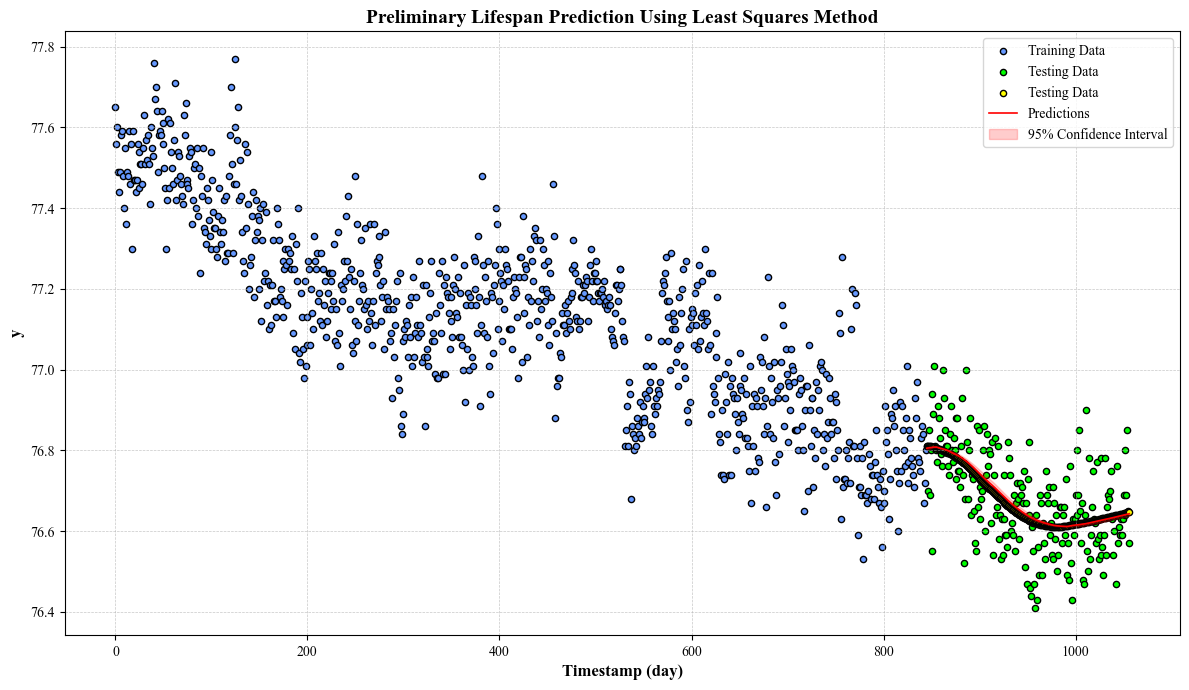

In [5]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(train_data['ds'], raw_data['y'].iloc[:numTrain], marker='o', facecolors="#6699FF", edgecolors='black', alpha=1, s=20,  label='Training Data')
ax.scatter(test_data['ds'], raw_data['y'].iloc[numTrain:], marker='o', facecolors="#00FF00", edgecolors='black', alpha=1, s=20, label='Testing Data')
ax.scatter(test_data['ds'], test_data['y'], marker='o', facecolors="yellow", edgecolors='black', alpha=1, s=20, label='Testing Data')
ax.plot(test_data['ds'], predicts[modelName], linestyle='-',color='red', linewidth=1.2, label='Predictions',zorder=4)
ax.fill_between(test_data['ds'], predicts['Lower'], predicts['Upper'],
				alpha=0.2, color='red', label='95% Confidence Interval', zorder=1)

ax.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax.set_ylabel('y', fontsize=12,fontweight='bold')
ax.set_title('Preliminary Lifespan Prediction Using Least Squares Method', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show() 

In [6]:
_,decay_period_years = predictLifespan(predicts, modelName, lifeDeclineInd = 0.1)
print('TWTs lifespan: ', decay_period_years)

TWTs lifespan:  20.432876712328767


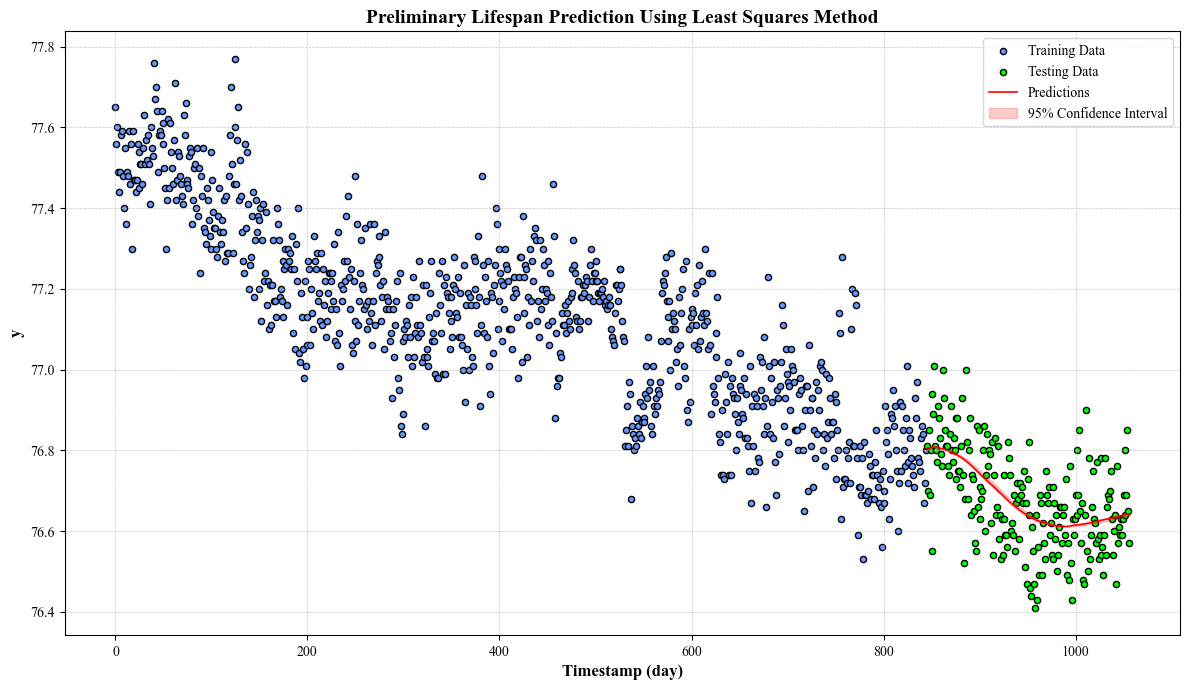

In [7]:
fig1, ax1 = plt.subplots(figsize=(12, 7))
ax1.scatter(train_data['ds'], raw_data['y'].iloc[:numTrain], marker='o', facecolors="#6699FF", edgecolors='black', alpha=1, s=20,  label='Training Data')
ax1.scatter(test_data['ds'], raw_data['y'].iloc[numTrain:], marker='o', facecolors="#00FF00", edgecolors='black', alpha=1, s=20, label='Testing Data')
ax1.plot(test_data['ds'], predicts[modelName], linestyle='-',color='red', linewidth=1.2, label='Predictions',zorder=4)
ax1.fill_between(test_data['ds'], predicts['Lower'], predicts['Upper'],
				alpha=0.2, color='red', label='95% Confidence Interval', zorder=1)

ax1.set_xlabel('Timestamp (day)', fontsize=12,fontweight='bold')
ax1.set_ylabel('y', fontsize=12,fontweight='bold')
ax1.set_title('Preliminary Lifespan Prediction Using Least Squares Method', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax1.legend()
plt.tight_layout()
if saveFig:
	fig1.savefig(f'./sourceModel/{modelName}/fig.png', dpi=300)
plt.show() 

In [8]:
saveModel = False
if saveModel:
	nf.save(path=f'./sourceModel/{modelName}/bestModel/', model_index=None, overwrite=True, save_dataset=True)

In [9]:
# from pytorch_lightning.loggers import TensorBoardLogger